# todo: 
 - figure out how to get the income data in
 - break down coefficients of the elasticnet

With a linear regression and elastic net model on a breakdown of the complaints and all of the census data we are getting 88% score towards predicting the number of arrests.  This score goes down towards 50ish when you exclude census data.  Census data includes demographics / race.    

In [124]:
import numpy as np
#import modin.pandas as pd
import pandas as pd

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

In [125]:
complaints = pd.read_csv('data/complaints_2018_final.csv')
arrests = pd.read_csv('data/nypd-arrest-data-year-to-date-1.csv')

populations = pd.read_csv('./data/nyc_2010pop_2020precincts.csv')
income = pd.read_csv('./data/income census data/ACSDT5Y2018.B19001_data_with_overlays_2020-11-06T124714.csv')
key = pd.read_csv('./data/precinct_block_key_2020.csv')

### Cleaning / EDA

In [126]:
# Creating complaints per precinct list
pct_complaints = complaints.groupby(['addr_pct_cd']).count()['cmplnt_num']

In [127]:
pct_complaints

addr_pct_cd
-99.0       747
 1.0      13326
 5.0       8885
 6.0      10105
 7.0       8246
          ...  
 115.0    15330
 120.0    14505
 121.0    11511
 122.0     9095
 123.0     4696
Name: cmplnt_num, Length: 78, dtype: int64

In [128]:
pct_complaints.drop(index=[-99], inplace=True)

In [129]:
pct_complaints.index = [int(pct) for pct in pct_complaints.index]

In [130]:
pct_complaints.index

Int64Index([  1,   5,   6,   7,   9,  10,  13,  14,  17,  18,  19,  20,  22,
             23,  24,  25,  26,  28,  30,  32,  33,  34,  40,  41,  42,  43,
             44,  45,  46,  47,  48,  49,  50,  52,  60,  61,  62,  63,  66,
             67,  68,  69,  70,  71,  72,  73,  75,  76,  77,  78,  79,  81,
             83,  84,  88,  90,  94, 100, 101, 102, 103, 104, 105, 106, 107,
            108, 109, 110, 111, 112, 113, 114, 115, 120, 121, 122, 123],
           dtype='int64')

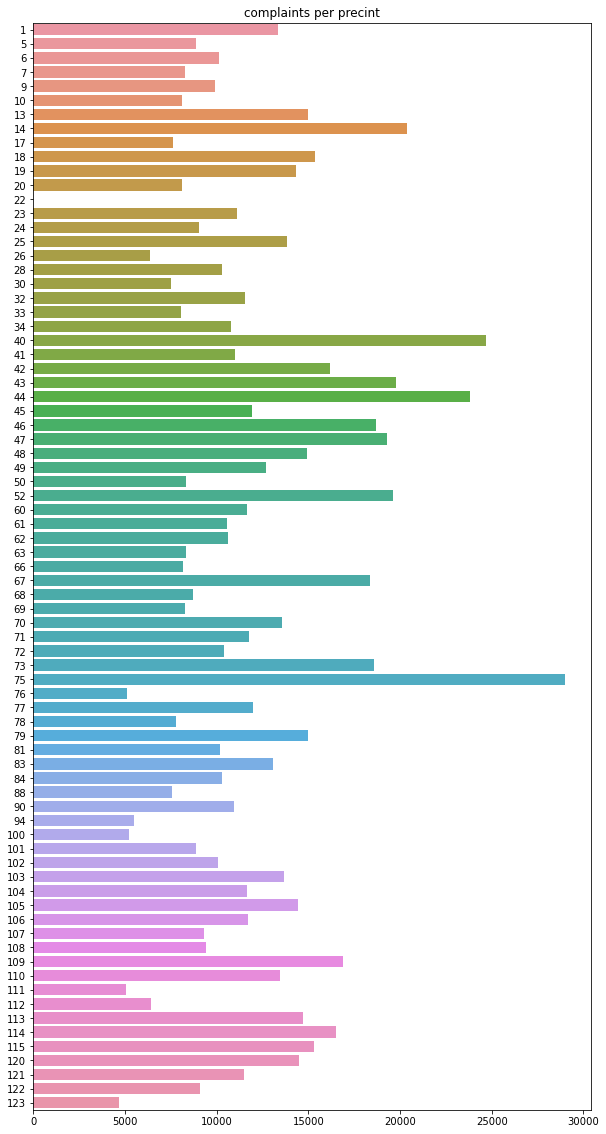

In [131]:
plt.figure(figsize=(10,20))
sns.barplot(pct_complaints.values, pct_complaints.index, orient='h')\
            .set(title='complaints per precint');

In [132]:
# snakecase the arrest dataframe
arrests = arrests.applymap(lambda x: x.strip().lower().replace(' ', '_') if type(x)==str else x)

new_ar_col_list = [col.strip().lower().replace(' ', '_') for col in arrests.columns]
arrests.columns = new_ar_col_list

In [133]:
# Creating arrests per precinct list
pct_arrests = arrests.groupby(['arrest_precinct']).count()['arrest_key']

In [134]:
pct_arrests

arrest_precinct
1      1454
5      2523
6      1439
7      1303
9      1339
       ... 
115    2261
120    2363
121    1332
122    1007
123     649
Name: arrest_key, Length: 77, dtype: int64

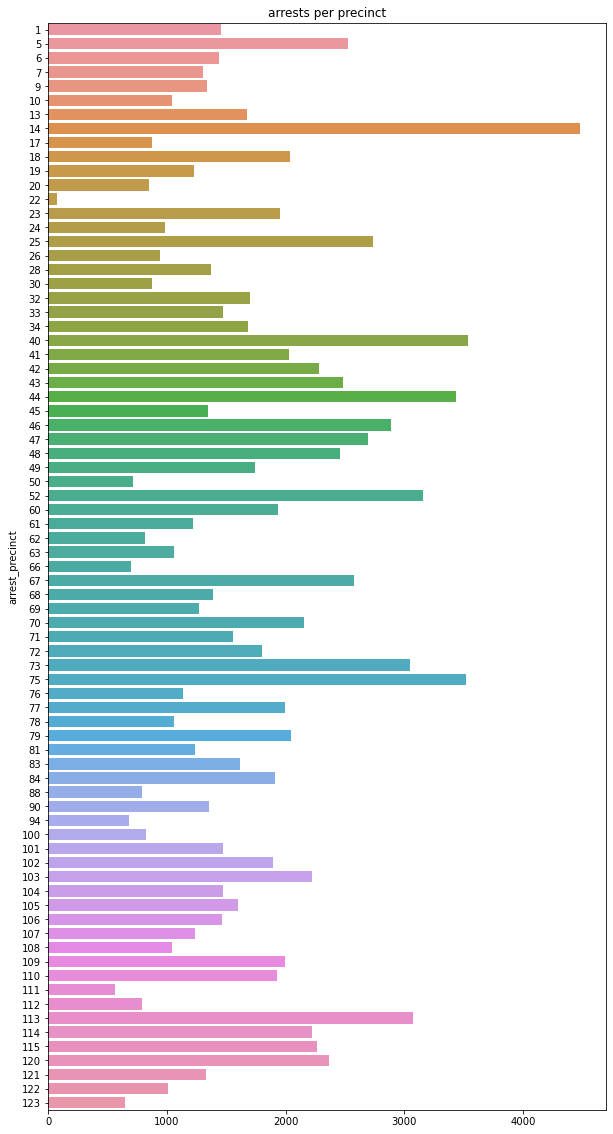

In [135]:
plt.figure(figsize=(10,20))
sns.barplot(pct_arrests.values, pct_arrests.index, orient='h')\
        .set(title='arrests per precinct');

In [136]:
# Create dataframe containing both arrest & complaint data for each precinct

cross = pd.concat([pct_arrests, pct_complaints], axis=1)
cross.reset_index(inplace=True)
cross.rename(columns={'arrest_key':'arrests', 'cmplnt_num':'complaints', 'index':'precinct'}, inplace=True)

In [140]:
cross = pd.concat([cross, populations], axis=1)

In [141]:
#[cross['arrests'] / populations[populations['precinct_2020']==each_pct]['P0010001'].values[0]

In [142]:
populations

,precinct_2020,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,P0010008,P0010009,...,P0020064,P0020065,P0020066,P0020067,P0020068,P0020069,P0020070,P0020071,P0020072,P0020073
0,1,66679,64416,50484,2162,89,10569,26,1086,2263,...,0,1,1,0,0,0,0,0,0,0
1,5,52568,51415,13436,2784,81,32795,18,2301,1153,...,0,1,1,0,0,0,0,0,0,0
2,6,62226,60490,53227,1316,80,5023,21,823,1736,...,0,2,2,0,0,0,0,0,0,0
3,7,56355,54055,21520,5992,326,19328,28,6861,2300,...,0,2,0,2,0,0,0,0,0,0
4,9,76443,73259,48175,6904,361,10946,45,6828,3184,...,0,2,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,115,171576,162076,66142,13700,1914,27250,85,52985,9500,...,0,5,1,4,0,0,0,0,0,0
73,120,113008,108593,58854,28373,686,8922,59,11699,4415,...,0,4,4,0,0,0,0,0,0,0
74,121,118708,114773,73769,16688,557,13217,78,10464,3935,...,0,0,0,0,0,0,0,0,0,0
75,122,138982,136452,119790,3397,330,8474,43,4418,2530,...,0,1,0,1,0,0,0,0,0,0


In [143]:
pct_list = set(cross['precinct'])

In [144]:
cross['arrests']

0     1454
1     2523
2     1439
3     1303
4     1339
      ... 
72    2261
73    2363
74    1332
75    1007
76     649
Name: arrests, Length: 77, dtype: int64

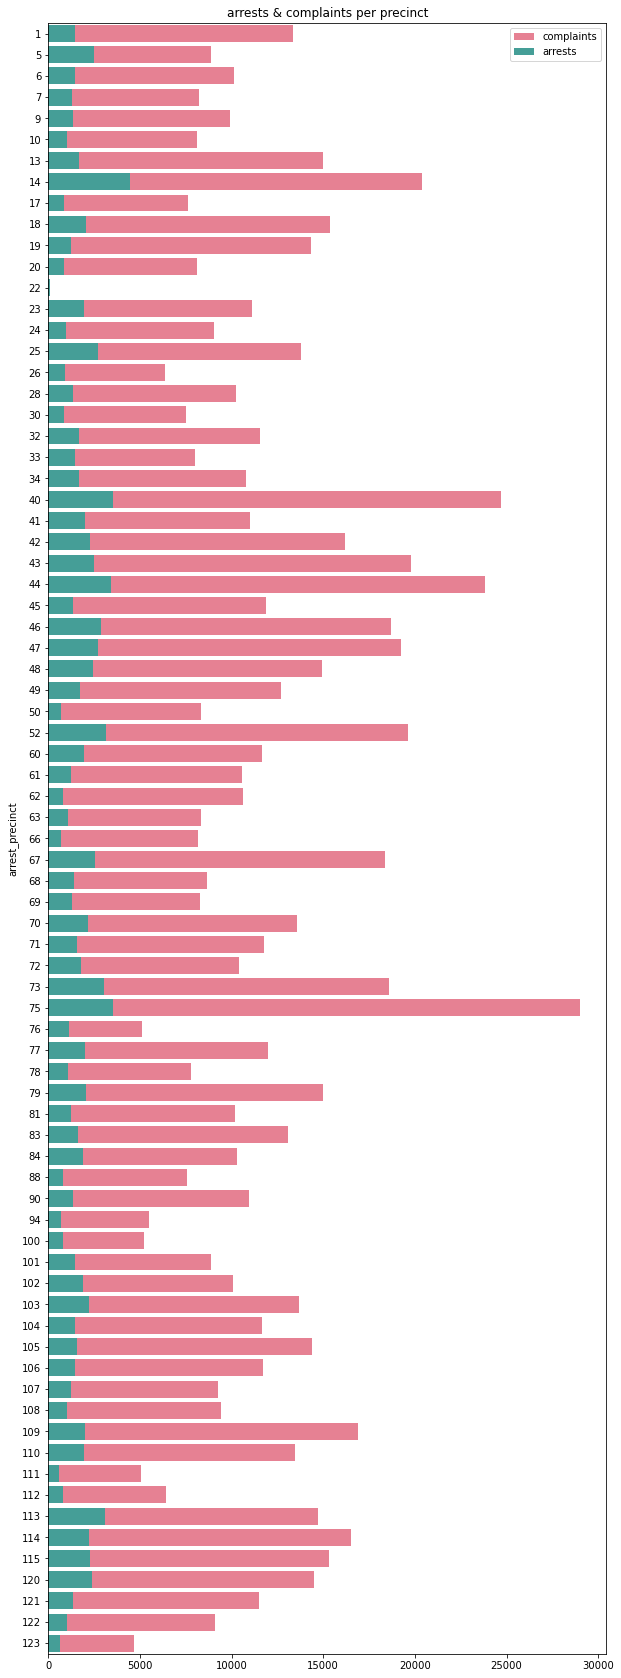

In [145]:
plt.figure(figsize=(10,30))
sns.barplot(pct_complaints.values, pct_complaints.index, orient='h',
            label='complaints',color=sns.husl_palette(2)[0]);
sns.barplot(pct_arrests.values, pct_arrests.index, orient='h',
            label='arrests', color=sns.husl_palette(2)[1])\
            .set(title='arrests & complaints per precinct');
plt.legend();

---

### Arrests by type per precinct

In [146]:
populations[populations['precinct_2020']==5]['P0010001'].values[0]

52568

In [147]:
arrest_counts

,"larceny,petit_from_open_areas,unclassified_arrests","larceny,grand_from_open_areas,unclassified_arrests",assault_3_arrests,"traffic,unclassified_misdemean_arrests","theft_of_services,_unclassified_arrests","forgery,etc.,unclassified-felony_arrests","criminal_mischief_4th,_graffiti_arrests","tampering_1,criminal_arrests","fraud,unclassified-felony_arrests","intoxicated_driving,alcohol_arrests",...,"bribery,fraud_arrests",use_of_a_child_in_a_sexual_per_arrests,false_report_bomb_arrests,"credit_card,unlawful_use_of_arrests",improper_passing_arrests,navigation_law_arrests,"controlled_substance,_possessi_arrests",obscene_material_-_under_17_ye_arrests,"weapons,disposition_of_arrests","forgery-illegal_possession,veh_arrests"
1,0.006764,0.001935,0.001410,0.001065,0.001005,0.000570,0.000555,0.000510,0.000450,0.000405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.002720,0.007419,0.002359,0.001845,0.000514,0.001636,0.000590,0.001103,0.000552,0.000419,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.003005,0.001768,0.001945,0.000723,0.000900,0.000514,0.000129,NaN,NaN,0.000595,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.001278,0.000639,0.002236,0.002644,0.000355,0.000515,0.000390,0.000142,0.000018,0.000390,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.001871,0.000994,0.001688,0.000994,0.000772,0.000144,0.000366,0.000013,0.000249,0.000170,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.000571,0.000291,0.001877,0.001294,0.000221,0.000187,0.000070,NaN,0.000006,0.000886,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120,0.001080,0.000699,0.002354,0.000681,0.000133,0.000142,0.000133,NaN,0.000009,0.000673,...,NaN,NaN,0.000009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121,0.001820,0.000354,0.000960,0.000463,0.000051,0.000084,0.000008,NaN,NaN,0.001078,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122,0.000525,0.000230,0.000849,0.000691,0.000029,0.000029,0.000230,NaN,0.000007,0.000374,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [148]:
# Breaks out counts of each type of arrest per precinct
# Expect to take a minute or two to run
arrest_counts = pd.DataFrame()
for each_pct in pct_list:
    # Summarize each crime type per precinct
    arrest_types = arrests[arrests['arrest_precinct']==each_pct]['pd_desc'].value_counts()
    arrest_types = pd.DataFrame(arrest_types.rename(each_pct)).T
    
    # Divide by precinct population to standardize as crime / person
    arrest_types /= populations[populations['precinct_2020']==each_pct]['P0010001'].values[0]
    
    # Append to the list
    arrest_counts = arrest_counts.append(arrest_types)

In [149]:
# change column headers to make it clear they refer to arrests
arr_type_cols = [(col+'_arrests') for col in arrest_counts.columns]
arrest_counts.columns = arr_type_cols

In [150]:
# We can add arrest types here
# cross = pd.merge(cross, crime_counts, left_on=('precinct'), right_index=True)

In [151]:
cross.head()

,precinct,arrests,complaints,precinct_2020,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,...,P0020064,P0020065,P0020066,P0020067,P0020068,P0020069,P0020070,P0020071,P0020072,P0020073
0,1,1454,13326,1,66679,64416,50484,2162,89,10569,...,0,1,1,0,0,0,0,0,0,0
1,5,2523,8885,5,52568,51415,13436,2784,81,32795,...,0,1,1,0,0,0,0,0,0,0
2,6,1439,10105,6,62226,60490,53227,1316,80,5023,...,0,2,2,0,0,0,0,0,0,0
3,7,1303,8246,7,56355,54055,21520,5992,326,19328,...,0,2,0,2,0,0,0,0,0,0
4,9,1339,9893,9,76443,73259,48175,6904,361,10946,...,0,2,1,1,0,0,0,0,0,0


### Complaints by type per precinct

In [152]:
# Breaks out counts of each type of complaint per precinct
# Expect to take a minute or two to run
complaint_counts = pd.DataFrame()
for each_pct in pct_list:
    # Summarize each crime type per precinct
    complaint_types = complaints[complaints['addr_pct_cd']==each_pct]['pd_desc'].value_counts()
    complaint_types = pd.DataFrame(complaint_types.rename(each_pct)).T
    
    # Divide by precinct population to standardize as crime / person
    complaint_types /= populations[populations['precinct_2020']==each_pct]['P0010001'].values[0]
    
    # Add to the list
    complaint_counts = complaint_counts.append(complaint_types)

In [153]:
# change column headers to make it clear they refer to complaints
comp_type_cols = [(col+'_complaints') for col in complaint_counts.columns]
complaint_counts.columns = comp_type_cols

In [154]:
cross = pd.merge(cross, complaint_counts, left_on=('precinct'), right_index=True)

In [155]:
cross.shape

(77, 517)

In [156]:
cross.isnull().sum()

precinct                                        0
arrests                                         0
complaints                                      0
precinct_2020                                   0
P0010001                                        0
                                               ..
traffic_unclassified_infractio_complaints      76
dis_con_aggravated_complaints                  74
disseminating_a_false_sex_offend_complaints    76
poss_meth_manufact_material_complaints         76
fac__sexual_offense_w_controll_complaints      76
Length: 517, dtype: int64

In [157]:
cross.fillna(0, inplace=True)

### EDA - by precinct

In [158]:
cross.head()

,precinct,arrests,complaints,precinct_2020,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,...,park_r&r_gambling_complaints,labor_law_employing_children_complaints,general_business_law___unclassified_complaints,firearms_licensing_laws_complaints,cigarette_no_tax_stamp_possess_complaints,traffic_unclassified_infractio_complaints,dis_con_aggravated_complaints,disseminating_a_false_sex_offend_complaints,poss_meth_manufact_material_complaints,fac__sexual_offense_w_controll_complaints
0,1,1454,13326,1,66679,64416,50484,2162,89,10569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,2523,8885,5,52568,51415,13436,2784,81,32795,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,1439,10105,6,62226,60490,53227,1316,80,5023,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7,1303,8246,7,56355,54055,21520,5992,326,19328,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9,1339,9893,9,76443,73259,48175,6904,361,10946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


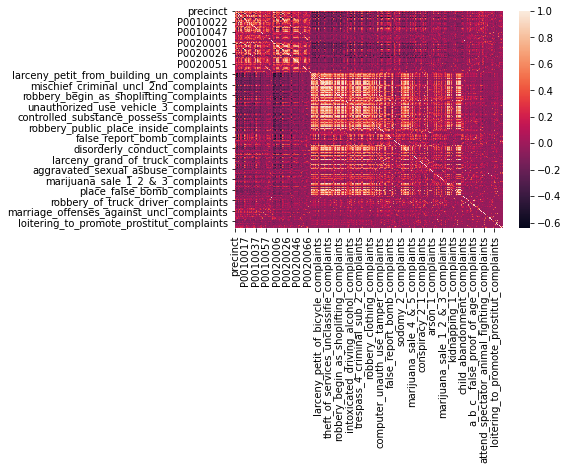

In [159]:
sns.heatmap(cross.corr())

### adding income by precinct

In [160]:
income.head()

,GEO_ID,NAME,B19001_001E,B19001_001M,B19001_002E,B19001_002M,B19001_003E,B19001_003M,B19001_004E,B19001_004M,...,B19001_013E,B19001_013M,B19001_014E,B19001_014M,B19001_015E,B19001_015M,B19001_016E,B19001_016M,B19001_017E,B19001_017M
0,id,Geographic Area Name,Estimate!!Total,Margin of Error!!Total,"Estimate!!Total!!Less than $10,000","Margin of Error!!Total!!Less than $10,000","Estimate!!Total!!$10,000 to $14,999","Margin of Error!!Total!!$10,000 to $14,999","Estimate!!Total!!$15,000 to $19,999","Margin of Error!!Total!!$15,000 to $19,999",...,"Estimate!!Total!!$75,000 to $99,999","Margin of Error!!Total!!$75,000 to $99,999","Estimate!!Total!!$100,000 to $124,999","Margin of Error!!Total!!$100,000 to $124,999","Estimate!!Total!!$125,000 to $149,999","Margin of Error!!Total!!$125,000 to $149,999","Estimate!!Total!!$150,000 to $199,999","Margin of Error!!Total!!$150,000 to $199,999","Estimate!!Total!!$200,000 or more","Margin of Error!!Total!!$200,000 or more"
1,1500000US360810845003,"Block Group 3, Census Tract 845, Queens County...",376,109,13,20,0,12,0,12,...,25,40,12,24,14,23,0,12,14,23
2,1500000US360810849001,"Block Group 1, Census Tract 849, Queens County...",559,136,135,93,29,32,21,26,...,0,12,121,95,87,69,0,12,0,12
3,1500000US360810383020,"Block Group 0, Census Tract 383.02, Queens Cou...",0,12,0,12,0,12,0,12,...,0,12,0,12,0,12,0,12,0,12
4,1500000US360810383021,"Block Group 1, Census Tract 383.02, Queens Cou...",0,12,0,12,0,12,0,12,...,0,12,0,12,0,12,0,12,0,12


In [161]:
income['GEO_ID'][5][9:]

'360810399003'

In [162]:
len(income['GEO_ID'][5][9:])

12

In [163]:
len(str(key['geoid10'][0]))

15

In [164]:
key

,geoid10,precinct_2020
0,360050001000001,NaN
1,360050001000002,NaN
2,360050001001000,114.0
3,360050001001001,114.0
4,360050001001002,114.0
...,...,...
39143,360859901000009,NaN
39144,360859901000010,NaN
39145,360859901000011,NaN
39146,360859901000012,NaN


In [165]:
str(key['geoid10'][0])[:12]

'360050001000'

In [166]:
key.head()
#key['pct_key'] = key.apply(lambda row: row['pct_key'], axis=1)

,geoid10,precinct_2020
0,360050001000001,NaN
1,360050001000002,NaN
2,360050001001000,114.0
3,360050001001001,114.0
4,360050001001002,114.0


In [167]:
# key.head(30)

In [168]:
sum(str(income['GEO_ID'][9:]) == str(key['geoid10'][0])[:12])

TypeError: 'bool' object is not iterable

In [169]:
key.astype('str')

,geoid10,precinct_2020
0,360050001000001,nan
1,360050001000002,nan
2,360050001001000,114.0
3,360050001001001,114.0
4,360050001001002,114.0
...,...,...
39143,360859901000009,nan
39144,360859901000010,nan
39145,360859901000011,nan
39146,360859901000012,nan


In [170]:
sum(income['GEO_ID'][9:] == key.astype('str')['geoid10'][4][:12])

0

In [171]:
key.astype('str')['geoid10'][4][:12]

'360050001001'

In [172]:
cross.isnull().sum()

precinct                                       0
arrests                                        0
complaints                                     0
precinct_2020                                  0
P0010001                                       0
                                              ..
traffic_unclassified_infractio_complaints      0
dis_con_aggravated_complaints                  0
disseminating_a_false_sex_offend_complaints    0
poss_meth_manufact_material_complaints         0
fac__sexual_offense_w_controll_complaints      0
Length: 517, dtype: int64

In [173]:
cross

,precinct,arrests,complaints,precinct_2020,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,...,park_r&r_gambling_complaints,labor_law_employing_children_complaints,general_business_law___unclassified_complaints,firearms_licensing_laws_complaints,cigarette_no_tax_stamp_possess_complaints,traffic_unclassified_infractio_complaints,dis_con_aggravated_complaints,disseminating_a_false_sex_offend_complaints,poss_meth_manufact_material_complaints,fac__sexual_offense_w_controll_complaints
0,1,1454,13326,1,66679,64416,50484,2162,89,10569,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
1,5,2523,8885,5,52568,51415,13436,2784,81,32795,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2,6,1439,10105,6,62226,60490,53227,1316,80,5023,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
3,7,1303,8246,7,56355,54055,21520,5992,326,19328,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,9,1339,9893,9,76443,73259,48175,6904,361,10946,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,115,2261,15330,115,171576,162076,66142,13700,1914,27250,...,0.0,0.0,0.0,0.000052,0.000000,0.0,0.000006,0.0,0.000006,0.000000
73,120,2363,14505,120,113008,108593,58854,28373,686,8922,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000018,0.0,0.000000,0.000009
74,121,1332,11511,121,118708,114773,73769,16688,557,13217,...,0.0,0.0,0.0,0.000000,0.000008,0.0,0.000000,0.0,0.000000,0.000000
75,122,1007,9095,122,138982,136452,119790,3397,330,8474,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000


---

## Modeling
Using complaint types & all 

In [259]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, ElasticNetCV, ElasticNet


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import StandardScaler

In [402]:
X = cross.drop(columns = ['arrests', 'precinct', 'precinct_2020'])
y = cross['arrests']

In [403]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [404]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)
X_sc = sc.fit_transform(X) # for use with cross-validated models

#### OLS Linear Regression

In [201]:
lm = LinearRegression(n_jobs=4)
lm.fit(X_train_sc, y_train)

LinearRegression(n_jobs=4)

In [205]:
lm.score(X_train_sc, y_train), lm.score(X_test_sc, y_test)

(1.0, 0.6474807034229788)

#### Ridge Linear Regression

In [218]:
r_alphas = np.logspace(0, 10, 1000)
ridge_cv = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)
ridge_cv.fit(X_train_sc, y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.02331658e+00, 1.04717682e+00, 1.07159340e+00,
       1.09657929e+00, 1.12214777e+00, 1.14831241e+00, 1.17508713e+00,
       1.20248614e+00, 1.23052400e+00, 1.25921561e+00, 1.28857621e+00,
       1.31862140e+00, 1.34936714e+00, 1.38082977e+00, 1.41302599e+00,
       1.44597292e+00, 1.47968806e+00, 1.51418933e+00, 1.54949504e+00,
       1.58562396e+00, 1.62259529e+0...
       5.88531578e+09, 6.02254120e+09, 6.16296626e+09, 6.30666554e+09,
       6.45371540e+09, 6.60419396e+09, 6.75818117e+09, 6.91575883e+09,
       7.07701066e+09, 7.24202233e+09, 7.41088152e+09, 7.58367791e+09,
       7.76050334e+09, 7.94145172e+09, 8.12661920e+09, 8.31610415e+09,
       8.51000725e+09, 8.70843150e+09, 8.91148232e+09, 9.11926760e+09,
       9.33189772e+09, 9.54948564e+09, 9.77214697e+09, 1.00000000e+10]),
        cv=5, scoring='r2')

In [219]:
ridge_cv.alpha_

1.0

In [220]:
ridge_cv.score(X_test_sc, y_test)

0.647251913781558

#### Elastic Net Linear Regression

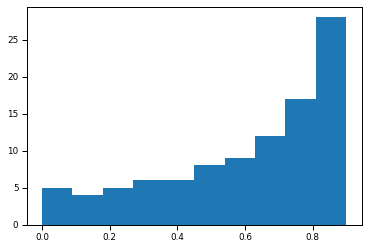

In [405]:
# Docs say we should check more values near 1 than 0
enet_ratio = np.abs(1 - np.logspace(-1, 0, 100))
plt.hist(enet_ratio);

In [406]:
enet_alphas = np.logspace(-1, 10, 100)
enet_model = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_ratio, cv=5, n_jobs=4, random_state=42)
enet_model.fit(X_train_sc, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2464.8102388767584, tolerance: 2368.814532608696
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5177.351537673152, tolerance: 2368.814532608696
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2848.0749278832154, tolerance: 2368.814532608696
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

ElasticNetCV(alphas=array([1.00000000e-01, 1.29154967e-01, 1.66810054e-01, 2.15443469e-01,
       2.78255940e-01, 3.59381366e-01, 4.64158883e-01, 5.99484250e-01,
       7.74263683e-01, 1.00000000e+00, 1.29154967e+00, 1.66810054e+00,
       2.15443469e+00, 2.78255940e+00, 3.59381366e+00, 4.64158883e+00,
       5.99484250e+00, 7.74263683e+00, 1.00000000e+01, 1.29154967e+01,
       1.66810054e+01, 2.154434...
       0.54651215, 0.53584112, 0.52491898, 0.51373984, 0.50229764,
       0.4905862 , 0.47859917, 0.46633008, 0.45377228, 0.44091898,
       0.42776323, 0.41429792, 0.40051575, 0.38640927, 0.37197086,
       0.35719269, 0.34206678, 0.32658493, 0.31073879, 0.29451977,
       0.2779191 , 0.2609278 , 0.24353667, 0.22573632, 0.2075171 ,
       0.18886917, 0.16978243, 0.15024656, 0.130251  , 0.10978491,
       0.08883724, 0.06739665, 0.04545154, 0.02299004, 0.        ]),
             n_jobs=4, random_state=42)

In [407]:
enet_model.alpha_

0.1

In [408]:
enet_model.l1_ratio_

0.8126182577139616

In [409]:
enet_model.score(X_test_sc, y_test)

0.8852313709958177

---

In [410]:
preds = enet_model.predict(X_test_sc)

In [411]:
preds

array([1290.09904819, 1080.61884138, 1203.87483117, 1483.68676873,
       2712.4925339 ,  823.56536373, 1663.52143832, 1280.17572152,
       2046.56301479, 2482.43611926,  684.78918885, 1478.63388429,
       1393.74244277,  511.37072376, 1722.73460775, 2841.86281075,
       2038.82242399, 1376.03539402, 1642.90106179, 3465.77971638])

In [412]:
results = pd.DataFrame(y_test)

results['class'] = 'target'

results.reset_index(inplace=True)
results.rename(columns={'index':'sample'}, inplace=True)
#results.drop(columns='level_0', inplace=True)

In [413]:
preds_df = pd.DataFrame(preds)
preds_df['sample']=results['sample']

preds_df.columns

preds_df.rename(columns={0:'arrests'}, inplace=True)
preds_df['class'] = 'prediction'

In [414]:
results = pd.concat([results, preds_df])

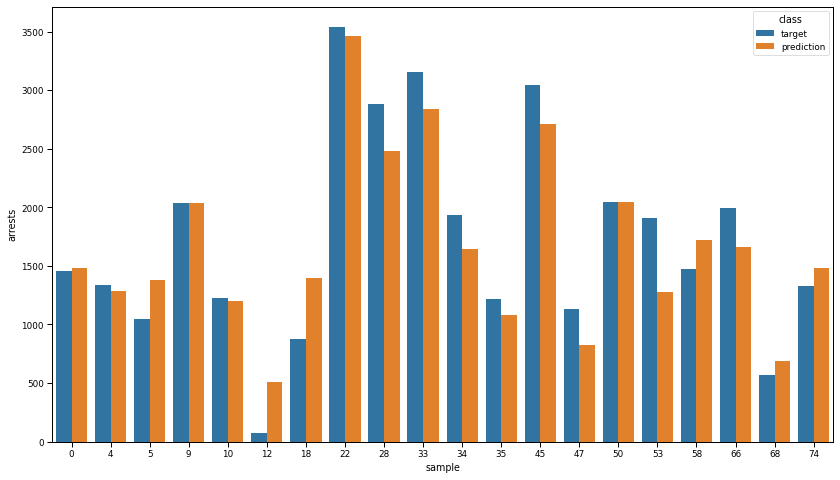

In [415]:
plt.figure(figsize=(14,8))
sns.set_context('paper')
rplot = sns.barplot(data=results, y='arrests', x='sample', hue='class')

#### Decision Tree

In [416]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_sc, y_train)

DecisionTreeRegressor(random_state=42)

In [417]:
dt.score(X_train_sc, y_train), dt.score(X_test_sc, y_test)

(1.0, 0.5247977879274113)

#### Bagging

In [418]:
bag = BaggingRegressor()
bag.fit(X_train_sc, y_train)

BaggingRegressor()

In [419]:
bag.score(X_train_sc, y_train), bag.score(X_test_sc, y_test)

(0.933449481803606, 0.7456920806988749)

Trying with some tuning

In [420]:
bag_params = {'n_estimators': [20, 30, 40]}

In [421]:
bag2 = BaggingRegressor(n_jobs=4)
bag_search = GridSearchCV(bag2,
                          bag_params,
                          cv=5,
                          n_jobs=2,
                          verbose=0)

In [422]:
bag_search.fit(X_sc, y)

GridSearchCV(cv=5, estimator=BaggingRegressor(n_jobs=4), n_jobs=2,
             param_grid={'n_estimators': [20, 30, 40]})

In [423]:
bag_search.best_params_

{'n_estimators': 40}

In [424]:
bag_search.best_score_

0.5838599958987063

### Experimental / Extended EDA

In [ ]:
complaints[complaints['addr_pct_cd']==94]['zipcodes'].unique()

In [ ]:
complaints[complaints['zipcodes']==11206]['addr_pct_cd'].unique()

In [ ]:
complaints[complaints['addr_pct_cd']==1]['pd_desc'].value_counts()

In [ ]:
complaints

In [ ]:
arrests.columns

In [ ]:
arrests